In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
import pyneb as pn


In [2]:
def int_spec_SII(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y):
    y = np.sum(np.sum(wo_cube[:,brightest_pixel_y-2:brightest_pixel_y+3,brightest_pixel_x-2:brightest_pixel_x+3],axis=1),axis=1)
    y_err = np.sqrt(np.sum(np.sum(((wo_err[:,brightest_pixel_y-2:brightest_pixel_y+3,brightest_pixel_x-2:brightest_pixel_x+3]))**2,axis=1),axis=1))
    return y,y_err
    
def popt_central_fit(wo_wave,data,error,obj,z,p_init):
    k = 1+z
    select = (wo_wave>6700*k) & (wo_wave < 6750*k)
    popt_full_fit,pcov_full_fit = leastsq(single_gauss_SII,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 2
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(single_gauss_SII,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
        parameters_err = np.std(parameters_MC,1)  
    (amp_SII6716_error,amp_SII6731_error,vel_SII6731_error,vel_sigma_SII6731_error,amp_SII6716_br_error,amp_SII6731_br_error,vel_SII6731_br_error,vel_sigma_SII6731_br_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 



In [3]:
def plot(obj,wo_wave,data,error,z,popt_full_fit):
    (amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,m_fit,c_fit) = popt_full_fit
    offset_fit=0.0
    k = 1+z
    select = (wo_wave>6700*k) & (wo_wave < 6750*k)
    
    fit = test_gauss_SII(popt_full_fit,wo_wave[select]+offset_fit,data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    plt.plot(wo_wave[select],data[select],'ko',label='data')
    plt.plot(wo_wave[select],fit,'r-',label='fit')
   # plt.plot(wo_wave[select],residual,label='residual')
    plt.plot(wo_wave[select],continuum(wo_wave[select]+offset_fit,m_fit,c_fit) + SII_doublet_gauss(wo_wave[select]+offset_fit,amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit),'g-',label='SII_core')
    plt.plot(wo_wave[select],continuum(wo_wave[select]+offset_fit,m_fit,c_fit) + SII_doublet_gauss(wo_wave[select]+offset_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit),'b-',label='SII_wing')
    
    plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)")
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$) ")
    plt.legend()
    plt.show()     
    


In [4]:
def flux_ratio(amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit):
    ratio_core = (amp_SII6716_fit/amp_SII6731_fit)
    ratio_wing = (amp_SII6716_br_fit/amp_SII6731_br_fit)
    return ratio_core,ratio_wing 

def electron_density(ratio_core,ratio_wing):
    S2 = pn.Atom('S',2)
    Ne_core = S2.getTemDen(int_ratio=ratio_core,tem=1e4,wave1=6717,wave2=6731)
    Ne_wing = S2.getTemDen(int_ratio=ratio_wing,tem=1e4,wave1=6717,wave2=6731)
    return Ne_core, Ne_wing

In [5]:
def central_table(obj,popt_full_fit,parameters_err,Ne_core,Ne_wing,Ne_core_err,Ne_wing_err,destination_path_cube):
    (ne,ne_err) = ([Ne_core,Ne_wing],[Ne_core_err,Ne_wing_err])
    (popt,err) = (np.append(popt_full_fit,ne),np.append(parameters_err,ne_err))
    column_names={'amp_SII6716':0,'amp_SII6731':1,'vel_SII':2,'vel_sigma_SII':3,'amp_SII6716_br':4,'amp_SII6731_br':5,'vel_SII_br':6,
              'vel_sigma_SII_br':7,'m':8,'c':9,'n_e_core':10,'n_e_wing':11}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_central_fitSII.fits'%(obj),overwrite=True)

In [10]:
def algorithm_script(obj,z,p_init,prefix_path_cube="/Volumes/Seagate/Outflow_paper1_old"):
    print ('%s'%(obj))
    
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/MUSE/%s/%s.wo_absorption.fits'%(prefix_path_cube,obj,obj))
    
    [brightest_pixel_x,brightest_pixel_y] = [205,158]
    
    (data,error) = int_spec_SII(wo_cube,wo_err,brightest_pixel_x,brightest_pixel_y)
    
    k = 1+z
    select =(wo_wave>6700*k) & (wo_wave < 6750*k)
       
    plt.plot(wo_wave[select],data[select],'ko',label='data')
    
        
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,z,p_init)
    
    print (popt_full_fit)
    
    (amp_SII6716_fit,amp_SII6731_fit,vel_SII6731_fit,vel_sigma_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_SII6731_br_fit,vel_sigma_SII6731_br_fit,m_fit,c_fit) = popt_full_fit
    (amp_SII6716_err,amp_SII6731_err,vel_SII6731_err,vel_sigma_SII6731_err,amp_SII6716_br_err,amp_SII6731_br_err,vel_SII6731_br_err,vel_sigma_SII6731_br_err,m_err,c_err) = parameters_err
    plot(obj,wo_wave,data,error,z,popt_full_fit)
    
    (ratio_core,ratio_wing) = flux_ratio(amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit)
    
    print (ratio_core,ratio_wing)
    
    (Ne_core, Ne_wing) = electron_density(ratio_core,ratio_wing)
    
    print ('electron_density_core is',Ne_core)
    print ('electron_density_wing is',Ne_wing)
    
    MC_loops = 800
    Ne_core_temp = np.zeros(MC_loops)
    Ne_wing_temp = np.zeros(MC_loops)
    for m in range(MC_loops):
        (core,wing) = flux_ratio(np.random.normal(amp_SII6716_fit,amp_SII6716_err),np.random.normal(amp_SII6731_fit,amp_SII6731_err),np.random.normal(amp_SII6716_br_fit,amp_SII6716_br_err),np.random.normal(amp_SII6731_br_fit,amp_SII6731_br_err))
        out = electron_density(core,wing)
        Ne_core_temp[m]=out[0]
        Ne_wing_temp[m]=out[1]
    Ne_wing_temp[Ne_wing_temp > 20000] = np.nan
    Ne_wing_temp = Ne_wing_temp[np.logical_not(np.isnan(Ne_wing_temp))]
    plt.hist(Ne_wing_temp)
    plt.xlabel('Electron Density(/cc)')
    plt.ylabel('Number of Electrons')
    plt.show()
    Ne_core_err = np.nanstd(Ne_core_temp)
    Ne_wing_err = np.nanstd(Ne_wing_temp)
    low = np.percentile(Ne_wing_temp,16)
    high = np.percentile(Ne_wing_temp,84)
    print ('electron_density_core is',Ne_core, Ne_core_err)
    print ('electron_density_wing is',Ne_wing, Ne_wing_err)#,low,high
   # central_table(obj,popt_full_fit,parameters_err,Ne_core,Ne_wing,Ne_core_err,Ne_wing_err)
    #central_table(obj,popt_full_fit,parameters_err)

HE0040-1105
[ 3.22907533e-02  2.49662155e-02  1.24605823e+04  1.59767976e+02
  2.00000000e-01  2.00000000e-01  1.23070000e+04  3.00000000e+02
  5.69716159e-02 -3.92888027e-01]


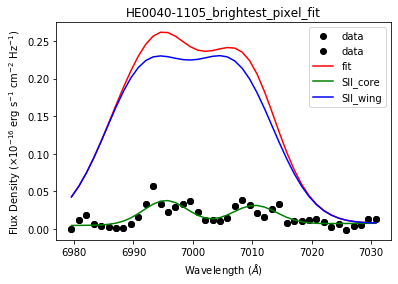

1.2933779753743726 1.0
electron_density_core is 113.42186641212268
electron_density_wing is 497.3080942268323


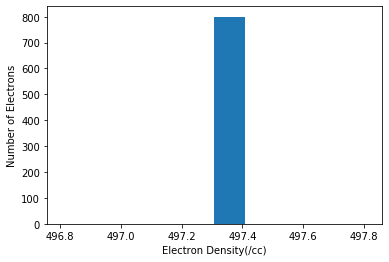

electron_density_core is 113.42186641212268 60.67735740652783
electron_density_wing is 497.3080942268323 1.7053025658242404e-13


In [11]:
z = {"HE0040-1105":0.041692}

objs = z.keys()

p_init = {'HE0040-1105':[1.8,1.8,12507,100,0.2,0.2,12307,300,-0.001,0.1]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 


HE0224-2834
[ 1.37493244e+00  1.15155210e+00  1.80434296e+04  1.27739685e+02
  2.67971427e-01  4.43867433e-01  1.79286739e+04  5.39417786e+01
 -5.32771718e+00  4.09155959e+01]
1.3749324436035704 0.0016386229061964297 1.1515520951705038 0.022003265611536205 0.2679714268463126 0.005350757401007211 0.44386743311099375 0.016254538257439582


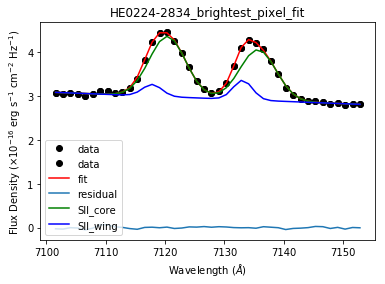

(1.193981973868053, 0.6037195046461169)
electron_density_core is 211.18086157626112
electron_density_wing is 3072.3724431682713


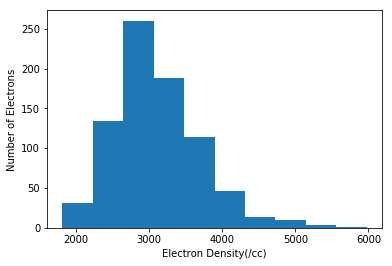

electron_density_core is 211.18086157626112 23.752962996891593
electron_density_wing is 3072.3724431682713 581.2465544666014


In [17]:
z = {"HE0224-2834":0.059800}

objs = z.keys()

p_init = {'HE0224-2834':[1.28347008e+00,1.08543217e+00,1.80556524e+04,1.23064387e+02,3.99785108e-01,5.61026655e-01,1.79296652e+04,6.42081964e+01,-6.73939395e+00,5.09879797e+01]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj]) 

HE1353-1917
[ 6.14711812e-01  4.84361289e-01  1.04979355e+04  8.21689914e+01
 -1.50233373e-01  1.74877981e-03  1.00999720e+04  2.23306147e+02
 -1.02534269e+01  7.47848587e+01]
0.6147118124161289 0.01395432085089593 0.48436128874708906 0.01253961723448499 -0.1502333732359743 0.012483544538501035 0.0017487798137126162 0.015372553383565909


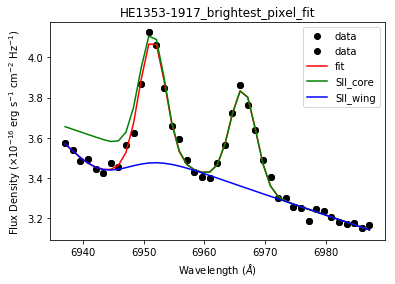

(1.2691183765040788, -85.90754082243926)
electron_density_core is 135.86036834984583
electron_density_wing is nan
(174.31642408939072, nan)
(108.56049609166693, nan)
(113.42186641212268, nan)
(103.90748878039275, nan)
(92.35836567957404, nan)
(85.31678524172806, nan)
(159.2121843475903, nan)
(122.78308640521904, nan)
(73.18921461198543, nan)
(234.9118451710983, nan)
(150.78533191282756, nan)
(130.0372622476918, nan)
(87.20612074929505, nan)
(150.78533191282756, nan)
(91.1112359839816, nan)
(140.02753925229712, nan)
(87.20612074929505, nan)
(153.7756357761819, nan)
(46.20456638974086, nan)
(122.4127005856696, nan)
(73.18921461198543, nan)
(124.0882844186546, nan)
(79.89084732933348, nan)
(177.2371166960079, nan)
(154.9414794734376, nan)
(157.53754255768436, nan)
(110.71341684829764, nan)
(129.0588081686739, nan)
(118.50093029739635, nan)
(211.18086157626112, nan)
(207.0742620941618, nan)
(179.66313659361543, nan)
(103.90748878039275, nan)
(120.85098507516645, nan)
(123.15459290632099, n

(76.46664874780345, nan)
(157.53754255768436, nan)
(142.8044996256324, nan)
(196.1141445827077, nan)
(201.51970567587665, nan)
(123.15459290632099, nan)
(130.0372622476918, nan)
(154.47408507460653, nan)
(219.97202901214385, nan)
(141.94423482245682, nan)
(183.2261315125698, nan)
(95.1912234049912, nan)
(260.7181253415102, nan)
(147.4071652442028, nan)
(214.07150311753986, nan)
(79.89084732933348, nan)
(171.96260170078793, nan)
(130.0372622476918, nan)
(164.59211914234527, nan)
(142.37371747820674, nan)
(148.3005385901094, nan)
(70.05225445653043, nan)
(126.5491449784114, nan)
(111.89031291730637, nan)
(145.85669220684667, nan)
(126.5491449784114, nan)
(200.60854121110506, nan)
(198.79855305103075, nan)
(105.01203706882445, nan)
(150.78533191282756, nan)
(153.7756357761819, nan)
(78.33729882205718, nan)
(187.7085036595387, nan)
(118.50093029739635, nan)
(115.67119558107059, nan)
(130.8253638564181, nan)
(216.34710726451544, nan)
(170.15384717431016, nan)
(198.198859989447, nan)
(87.206

(118.50093029739635, nan)
(166.84505443870094, nan)
(83.4683825107768, nan)
(95.1912234049912, nan)
(113.42186641212268, nan)
(175.37288322946864, nan)
(167.8562327235892, nan)
(129.64499357812412, nan)
(103.90748878039275, nan)
(186.29610733638182, nan)
(169.64056335012648, nan)
(161.02620275609394, nan)
(132.2160521833825, nan)
(157.53754255768436, nan)
(126.5491449784114, nan)
(133.6215236836225, nan)
(75.2065539109328, nan)
(95.1912234049912, nan)
(129.0588081686739, nan)
(62.785548240504255, nan)
(177.77338551785363, nan)
(206.44960463914194, nan)
(161.02620275609394, nan)
(103.90748878039275, nan)
(166.34175187451794, nan)
(189.70386615818802, nan)
(162.36960558948485, nan)
(150.78533191282756, nan)
(157.53754255768436, nan)
(136.2714429657542, nan)
(138.13672512715183, nan)
(132.2160521833825, nan)
(123.52722347983715, nan)
(108.56049609166693, nan)
(157.53754255768436, nan)
(96.78616377774233, nan)
(143.23658519662416, nan)
(92.0797586664583, nan)
(175.37288322946864, nan)
(179

/home/mainak/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


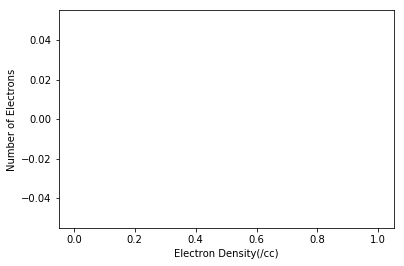

IndexError: cannot do a non-empty take from an empty axes.

In [22]:
z = {"HE1353-1917":0.03521}

objs = z.keys()

p_init = {'HE1353-1917':[1,1,10363,120,0.5,0.5,10363,200,-0.001,0.1]}


for obj in objs:
    algorithm_script(obj,z[obj],p_init[obj])
    
# It is suspicious. But also something to do with its strong wing.
